In [5]:
import numpy as np
import pandas as pd
import os.path
import scipy
import seaborn as sns
from scipy.stats import gengamma, laplace, norm
from scipy.stats import kstwobign, kstest, ks_1samp, anderson, anderson_ksamp, cramervonmises, kstwo, ksone
from scipy.special import kolmogorov
import matplotlib.pyplot as plt
from utilities import *
from plot_utilities import *
%matplotlib inline
import pickle

np.random.seed(42)

In [6]:
# Note that the code below assumes you are in testing-framework. Can check Current Working Directory below:
# Should be testing-framework
os.getcwd()

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\testing-framework'

In [7]:
# Choice of CDFs already computed in the following format
# cdfs_{num_points}_{min_r}-{max_r}-{stepsize}_{min_eta}-{max_eta}-{stepsize}.pickle
os.listdir('CDFs/')

['.DS_Store',
 '100',
 '100000',
 'cdfs_100000_0.1-2.9-0.1_0-4-0.2.pickle',
 'cdfs_100000_3.0-7-0.4_0.1-4-0.2.pickle',
 'cdfs_10000_0.1-5-0.1_0-4-0.2.pickle',
 'cdfs_1000_0.1-5-0.1_0-4-0.2.pickle',
 'cdfs_1000_5.1-15-0.1_0-4-0.2.pickle',
 'cdfs_lite.pickle',
 'combined_100.pickle',
 'combined_layer3_10000.pickle',
 'combined_layer4_10000.pickle',
 'combined_layer5_10000.pickle',
 'combined_layer6_10000.pickle',
 'layer2_10000',
 'layer3_10000',
 'layer4_10000',
 'layer5_10000',
 'layer6_10000',
 'optimize_cdfs_1000.pickle',
 'optimize_cdfs_10000.pickle',
 'updated_100000.zip',
 'updated_100000_backup.pickle']

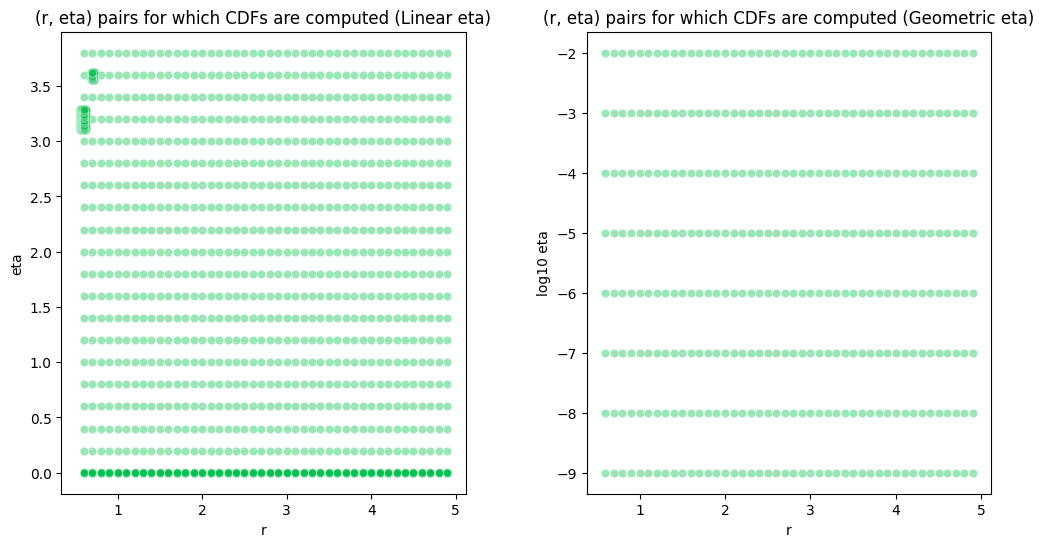

In [10]:
all_cdfs = combine_pickles(dir_name = '100') | combine_pickles(dir_name = 'layer2_10000') | combine_pickles(dir_name = 'layer3_10000') 

all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : all_cdfs.items()})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

Best parameters (0.6, 3.16) with KS-test Statistic 0.0365 and pvalue 0.00040963539160938553, layer 2 with num_samples=3180


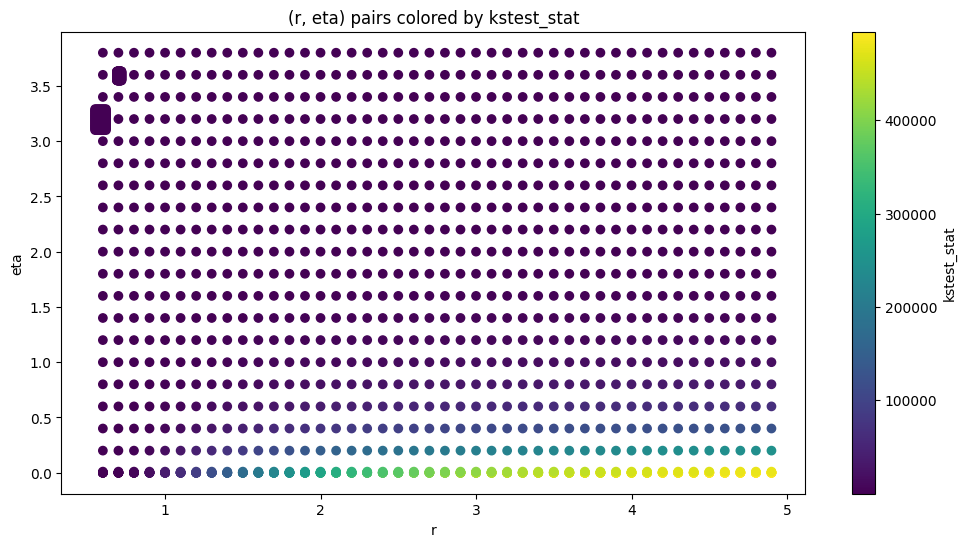

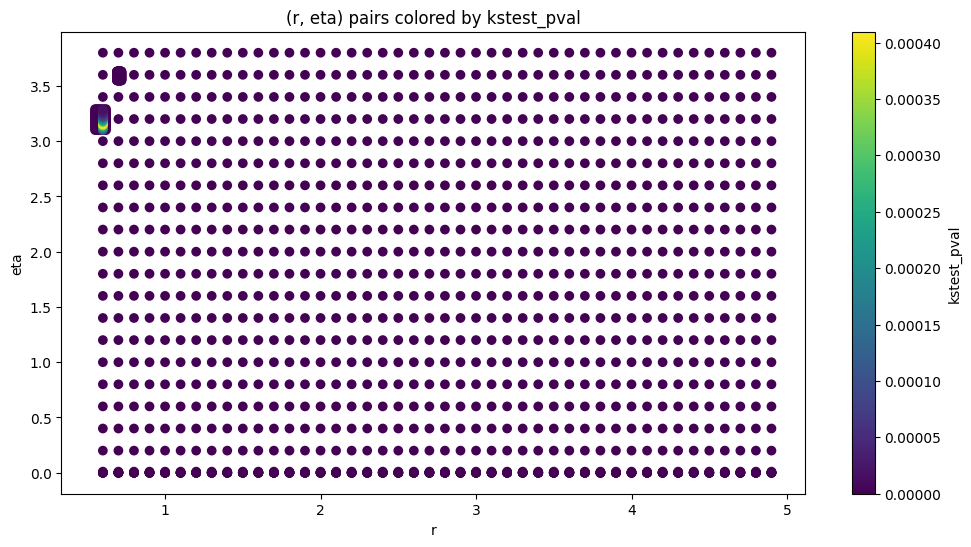

,"(r,eta),cdf",r,eta,cdf,kstest_stat,kstest_pval
0,"((0.6, 0), <scipy.interpolate._cubic.CubicSpli...",0.6,0.0,<scipy.interpolate._cubic.CubicSpline object a...,9.163482,0.000000e+00
1,"((0.6, 0.2), <scipy.interpolate._cubic.CubicSp...",0.6,0.2,<scipy.interpolate._cubic.CubicSpline object a...,0.272536,3.534280e-209
2,"((0.6, 0.4), <scipy.interpolate._cubic.CubicSp...",0.6,0.4,<scipy.interpolate._cubic.CubicSpline object a...,0.251178,2.799823e-177
3,"((0.6, 0.6), <scipy.interpolate._cubic.CubicSp...",0.6,0.6,<scipy.interpolate._cubic.CubicSpline object a...,0.241636,6.410581e-164
4,"((0.6, 0.8), <scipy.interpolate._cubic.CubicSp...",0.6,0.8,<scipy.interpolate._cubic.CubicSpline object a...,0.227699,2.189204e-145


In [14]:
# Experimental cell to play around with different layers
data_dict = pd.read_pickle('../data/Panoptic Agriculture/Transformed Dataset/Panoptic_Data_Dict_Normalized.pickle')

layer = 2
obs_x = create_obs_x(data_dict, layer)
df = make_layer_df(obs_x, all_cdfs_df)
total_samples = obs_x.size
r_prime, eta_prime, kstest_stat, kstest_pval = find_best_metric(obs_x, all_cdfs_df)
print(f"Best parameters {(r_prime, eta_prime)} with KS-test Statistic {np.round(kstest_stat, 4)} and pvalue {kstest_pval}, layer {layer} with num_samples={total_samples}")
#distance, location = visualize_cdfs(obs_x, r_prime, eta_prime, all_cdfs)
create_scatter_plot(df, 'kstest_stat')
create_scatter_plot(df, 'kstest_pval')
df.head()

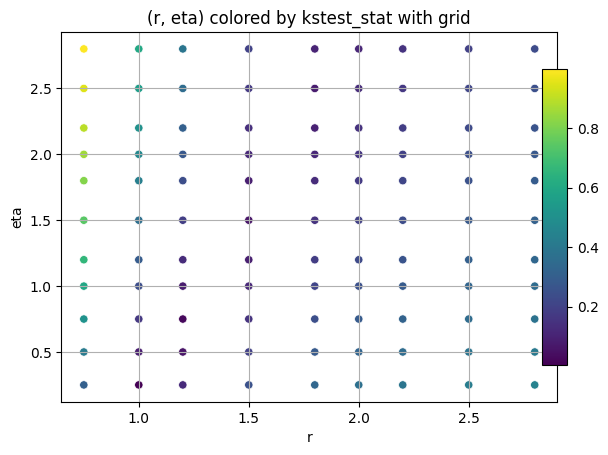

In [20]:
metric = 'kstest_stat'
ax = sns.scatterplot(x="r", y="eta", hue=metric, data=df[(df['r'] > 0.5) & (df['eta'] > 0.1)], palette="viridis")

norm = plt.Normalize(df[metric].min(), df[metric].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm, cax=ax.inset_axes([0.97, 0.1, 0.05, 0.8]))

ax.set_xlabel('r')
ax.set_ylabel('eta')
ax.set_title(f'(r, eta) colored by {metric} with grid')
plt.grid(True)
plt.show()

In [11]:
df0 = df[(df['r'] > 0) & (df['eta'] >= 0.1)]
indices = df0.index
x = np.array(df0['r'].loc[indices])
y = np.array(df0['eta'].loc[indices])
z = np.array(df0['kstest_stat'].loc[indices]) 
X, Y = np.meshgrid(df0['r'].unique(), df0['eta'].unique())

dims_r = df0['r'].unique().size
dims_eta = df0['eta'].unique().size
fig, ax = plt.subplots()
CS = ax.contour(x.reshape(dims_r, dims_eta), y.reshape(dims_r, dims_eta), z.reshape(dims_r, dims_eta), np.append(np.arange(0.04, 0.3, 0.02), 0.3), cmap =  'viridis')
ax.clabel(CS, CS.levels, inline=True, fontsize=10)
create_contour_plot(df0,'kstest_stat')

NameError: name 'df' is not defined

In [ ]:
%%time
# cdfs_name = 'updated_100000', 'updated_1000_0.1-4.9_0.0-3.8'
cdfs_name = 'updated_100000'
if os.path.isfile(f'panoptic/CSVs/best_params_df_{cdfs_name}.csv'):
    best_params_df = pd.read_csv(f'panoptic/CSVs/best_params_df_{cdfs_name}.csv')
else:
    obs_x_dict = dict()
    df_dict = dict()
    #best_params_df = pd.DataFrame(columns = ['layer', 'num_samples', 'r', 'eta', 'kstest_stat', 'kstest_pval'])
    # Can take a very long time to run, better to run it in a .py
    for i, layer in enumerate(np.arange(8, 9)): 
        obs_x = create_obs_x(data_dict, layer)
        obs_x_dict[layer] = obs_x
        df = make_layer_df(obs_x, all_cdfs_df)
        df_dict[layer] = df
        n = obs_x.size
        #result = find_best_metric(obs_x, all_cdfs_df)
        #best_params_df.loc[i, :] = np.append(np.array([layer, n]), result)
        
    #best_params_df = best_params_df.set_index('layer')
    #best_params_df.to_csv(f'panoptic/CSVs/best_params_df_{cdfs_name}.csv')
best_params_df


CPU times: total: 0 ns
Wall time: 0 ns


,layer,num_samples,r,eta,kstest_stat,kstest_pval
0,2.0,3180.0,0.50,1.20,0.061902,4.904739e-11
1,3.0,12720.0,0.50,0.75,0.060532,5.863370e-41
2,4.0,50880.0,0.75,2.20,0.020453,6.401431e-19
3,5.0,203520.0,1.00,2.50,0.012450,7.855588e-28
4,6.0,814080.0,1.00,0.25,0.005306,2.481943e-20


In [22]:
%%time
# Creates validation dataframes 
# For now, it caps out at 6. For layer 7 and up it just defaults to 2.9, 0

# for layer in range(6, 8):
#     obs_x = create_obs_x(data_dict, layer)
#     df = make_layer_df(obs_x, all_cdfs_df)
#     total_samples = obs_x.size
#     all_num_samples = np.sort(np.append(5*10**np.arange(3.0, np.floor(np.log10(total_samples))), 10**np.arange(3.0, np.ceil(np.log10(total_samples)))))
#     print(list(all_num_samples))
#     np.random.seed(42)
#     x = obs_x[np.random.permutation(total_samples)]
#     val_df = pd.concat([val_df_fixed_num(x, n, all_cdfs_df) for n in all_num_samples])
#     val_df.to_csv(f'panoptic/CSVs/val_df{layer}_{cdfs_name}.csv')
#     val_df.value_counts(['r', 'eta'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
val_df = pd.read_csv(f'panoptic/CSVs/val_df{4}.csv', index_col='Unnamed: 0')
print(val_df.value_counts(['r', 'eta'])[:10])

r    eta
0.8  3.0    141
     3.2    107
     2.8     76
     3.4     65
0.7  1.8     36
0.8  3.6     33
     3.8     29
0.7  1.6     26
     2.0     23
0.8  2.6     23
Name: count, dtype: int64


FileNotFoundError: [Errno 2] No such file or directory: 'panoptic/CSVs/val_df6_cdfs_lite.csv'

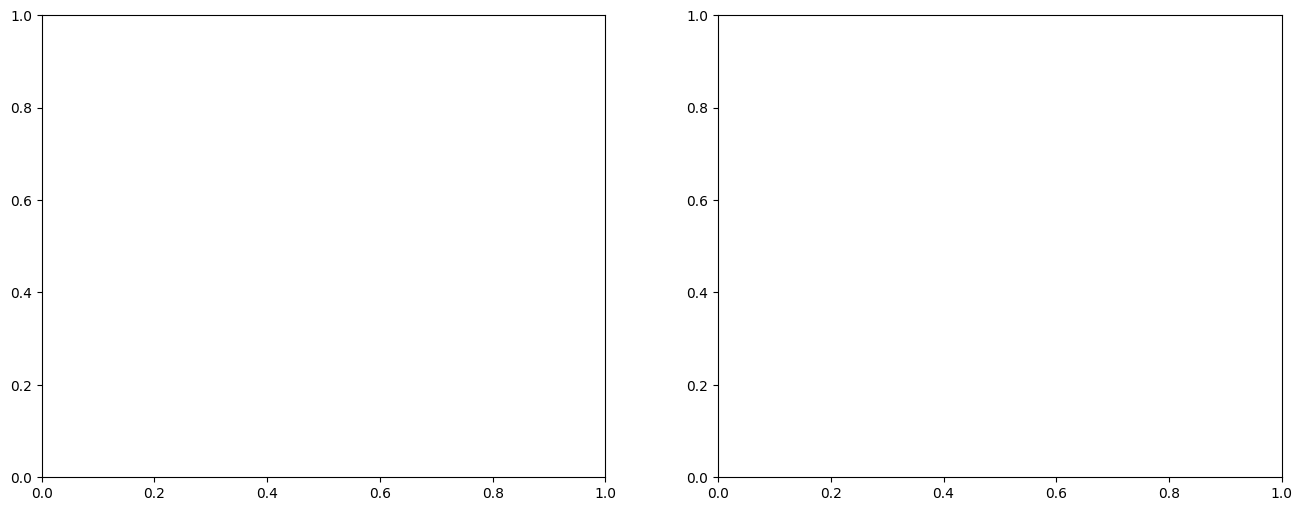

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with two subplots

for layer in np.arange(layer, layer+1):
    #obs_x = obs_x_dict[layer]
    #df = df_dict[layer]
    total_samples = obs_x.size
    x = obs_x[np.random.permutation(total_samples)]
    val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}_{cdfs_name}.csv', index_col='Unnamed: 0')

    # Scatter plot
    sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis=1), x='r', y='eta', palette='bright', hue='num_samples', alpha=0.4, ax=ax1)
    r, eta = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
    ax1.scatter(x=r, y=eta, marker="*", label='all_data', s=60, color='xkcd:shamrock green', alpha=0.7)
    ax1.set_title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
    print(r, eta)
    ax1.legend()

    # KDE plot
    sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis=1), x='r', y='eta', palette='bright', hue='num_samples', alpha=0.4, ax=ax2)

plt.tight_layout()
plt.show()

0.9 1.6


C:\Users\yashd\AppData\Local\Temp\ipykernel_41308\293657630.py:17: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
C:\Users\yashd\AppData\Local\Temp\ipykernel_41308\293657630.py:17: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
C:\Users\yashd\AppData\Local\Temp\ipykernel_41308\293657630.py:17: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 

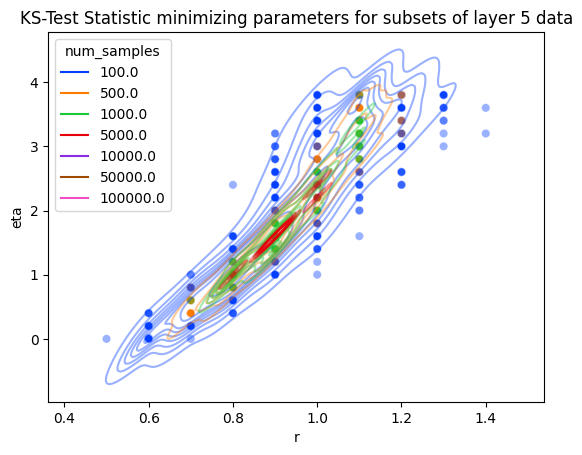

In [62]:
np.random.seed(42)

# TODO: Put plots side by side
for layer in np.arange(layer, layer+1):
    obs_x = obs_x_dict[layer]
    df = df_dict[layer]
    total_samples = obs_x.size
    x = obs_x[np.random.permutation(total_samples)]
    val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}.csv', index_col='Unnamed: 0')
    sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
    r, eta, = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
    plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
    plt.title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
    print(r, eta)
    plt.legend()
    
    sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
    

Text(0.5, 1.0, 'Validation')

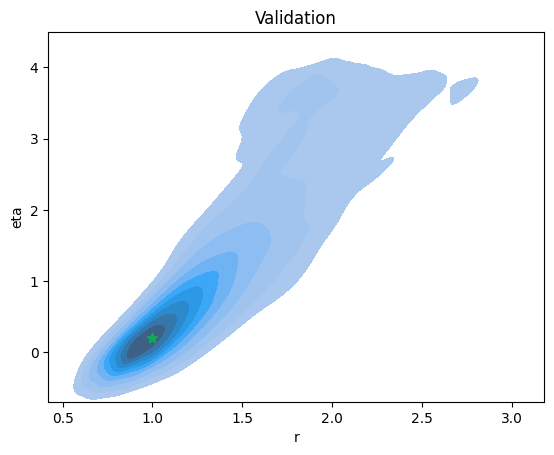

In [47]:
layer = 6
val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}.csv', index_col='Unnamed: 0')
mask = val_df['num_samples'] == 100
sns.kdeplot(val_df.drop(['kstest_pval'], axis = 1)[mask], x = 'r', y = 'eta', fill=True)
r, eta, = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
plt.title('Validation')